# Setup

## Imports & Settings

In [1]:
%load_ext autoreload
%autoreload 2

import os
import re
import scanpy as sc
import pandas as pd
import numpy as np
import corescpy as cr

# Computing Resources
gpu = False
sc.settings.n_jobs = 4
sc.settings.max_memory = 150

# Display
pd.options.display.max_colwidth = 1000
pd.options.display.max_columns = 100
pd.options.display.max_rows = 500
sc.settings.set_figure_params(dpi=100, frameon=False, figsize=(20, 20))

# Column Names (from Metadata & To Be Created)
col_sample_id_o, col_sample_id = "Sample ID", "Sample"  # in metadata, new
col_subject = "Patient"  # in metadata file
col_inflamed, col_stricture = "Inflamed", "Stricture"  # in metadata file
col_condition = "Condition"  # constructed from col_inflamed & col_stricture
col_fff = "file_path"  # column in metadata in which to store data file path
col_tangram = "tangram_prediction"  # for future Tangram imputation annotation

ryp2 is not installed. Install with pip install rpy2 to run tools with R support.

## Options & Data

In [3]:
# Directories & Metadata
load, reannotate = True, True
run = "CHO-009"
# run = ["CHO-001", "CHO-002"]
# run = ["CHO-001", "CHO-002", "CHO-005", "CHO-006", "CHO-007"]
samples = "all"
# samples = ["50564A4", "50618B5"]
# samples = ["50007B2"]
# samples = ["50452A", "50452B", "50452C"]
# samples = ["50564A4", "50618B5"]

# Optionally, Define Manual Annotation Versions
# should be stored in ("<out_dir>/annotations_dictionaries")
# in format <selves[i]._library_id>___leiden_<man_anns[i]>_dictionary.xlsx
# with first column = leiden cluster and second column = annotation
# man_anns = True  # load manual annotations according to clustering kws
# man_anns = ["res0pt5_dist0pt5_npc30", "res0pt75_dist0pt3_npc30",
#             "res1pt5_dist0_npc30"]  # choose manual annotations to load
man_anns = None  # do not load manual annotations

# Main Directories
# Replace manually or mirror my file/directory tree in your home (`ddu`)
ddu = os.path.expanduser("~")
ddm = "/mnt/cho_lab" if os.path.exists("/mnt/cho_lab") else "/mnt"  # Spark?
ddl = f"{ddm}/disk2/{os.getlogin()}/data/shared-xenium-library" if (
    "cho" in ddm) else os.path.join(ddu, "shared-xenium-library")
ddx = f"{ddm}/bbdata1"  # mounted drive Xenium folder
out_dir = os.path.join(ddl, "outputs", "TUQ97N", "nebraska")  # None = no save
d_path = os.path.join(ddm, "disk2" if "cho" in ddm else "",
                      os.getlogin(), "data")  # other, e.g., Tangram data
anf = pd.read_csv(os.path.join(ddu, "corescpy/examples/markers_lineages.csv"))
file_mdf = os.path.join(ddl, "samples.csv")  # metadata

# Annotation & Tangram Imputation
col_assignment = "Bin"  # which column from annotation file to use
# col_cell_type_sc, file_sc = "ClusterAnnotation", str(
#     f"{d_path}/2023-05-12_CombinedCD-v2_ileal_new.h5ad")
col_cell_type_sc, file_sc = "cell_type", f"{d_path}/elmentaite_ileal.h5ad"
# file_sc = None  # to skip Tangram imputation/label transfer

# Processing & Clustering Options
kws_pp = dict(cell_filter_pmt=None, cell_filter_ncounts=[50, None],
              cell_filter_ngene=[10, None], gene_filter_ncell=[3, None],
              gene_filter_ncounts=[3, None], custom_thresholds=None,
              kws_scale=dict(max_value=10, zero_center=True),
              method_norm="log")  # preprocessing keyword arguments
kws_cluster = dict(kws_umap=dict(method="rapids" if gpu else "umap"),
                   genes_subset=list(anf.iloc[:, 0]),  # use only markers
                   use_gpu=gpu, use_highly_variable=False)
kws_clustering, col_assignment = {}, []
for i in zip([0.5, 0.75, 1.5], [0.5, 0.3, 0], [30, 30, 30]):
    kws = {**kws_cluster, "resolution": i[0], "kws_umap": {
        **kws_cluster["kws_umap"], "min_dist": i[1]}, "n_comps": i[2]}
    suff = str(f"res{re.sub('[.]', 'pt', str(kws['resolution']))}_dist"
               f"{re.sub('[.]', 'pt', str(kws['kws_umap']['min_dist']))}"
               f"_npc{kws['n_comps']}")  # file path suffix
    kws_clustering.update({suff: kws})
    col_assignment += ["group" if kws["resolution"] >= 0.7 else "Bucket"]
if man_anns is True:
    man_anns = list(kws_clustering.keys())
col_cell_type = list(kws_clustering.keys())[-1] if (
    man_anns is None) else f"manual_{man_anns[-1]}"  # default cell labels

# After this point, no more options to specify
# Just code to infer the data file path from your specifications
# and construct argument dictionaries and manipulate metadata and such.

# Read Metadata & Other Information
metadata = (pd.read_excel if file_mdf[-4:] == "xlsx" else pd.read_csv)(
    file_mdf, dtype={"Slide ID": str}).rename({
        "Name": col_subject, "Inflammation": col_inflamed}, axis=1)
if samples not in ["all", None]:  # subset by sample ID?
    metadata = metadata.set_index(col_sample_id_o).loc[samples].reset_index()

# Revise Metadata & Construct Variables from Options
metadata.loc[:, col_condition] = metadata.apply(lambda x: "Stricture" if x[
    col_stricture].lower() in ["stricture", "yes"] else x[
        col_inflamed].capitalize(), axis=1)  # inflamation/stricture condition
metadata.loc[:, col_sample_id] = metadata[[col_condition, col_sample_id_o]
                                          ].apply("-".join, axis=1)
metadata = metadata.set_index(col_sample_id)
fff = np.array(cr.pp.construct_file(run=run, directory=ddx))
bff = np.array([os.path.basename(i) for i in fff])  # base path names
samps = np.array([i.split("__")[2].split("-")[0] for i in fff])
for x in metadata[col_sample_id_o]:
    m_f = metadata[metadata[col_sample_id_o] == x][
        "out_file"].iloc[0]  # ...use to find unconventionally-named files
    locx = np.where(samps == x)[0] if pd.isnull(
        m_f) else np.where(bff == m_f)[0]
    metadata.loc[metadata[col_sample_id_o] == x, col_fff] = fff[locx[0]] if (
        len(locx) > 0) else np.nan  # assign output file to metadata row
metadata = metadata.dropna(subset=[col_fff]).drop_duplicates()

# Annotation File
assign = anf.dropna(subset=col_assignment).set_index(
    "gene").rename_axis("Gene")  # markers
assign = assign[~assign.Quality.isin([-1])]  # drop low-quality markers

# Print Metadata & Make Output Directory (If Not Present)
print(metadata)
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

# Load Data
kws_init = dict(col_sample_id=col_sample_id, col_subject=col_subject,
                col_cell_type=col_cell_type)  # object creation arguments
selves = [None] * metadata.shape[0]  # to hold different samples
for i, x in enumerate(metadata.index.values):
    selves[i] = cr.Spatial(metadata.loc[x][col_fff], library_id=x, **kws_init)
    for j in metadata:  # iterate metadata columns
        selves[i].rna.obs.loc[:, j] = str(metadata.loc[x][j])  # add to object
    selves[i].rna.obs.loc[:, "out_file"] = os.path.join(
        out_dir, selves[i]._library_id)  # output path (to save object)
    if load is True:
        if os.path.exists(str(selves[i].rna.obs.out_file.iloc[0])):
            selves[i].update_from_h5ad(selves[i].rna.obs.out_file.iloc[0])
        print(selves[i].rna)

# Marker Gene Dictionary (for Scanpy Plotting)
marker_genes_dict = dict(assign["Bucket"].reset_index().groupby(
    "Bucket").apply(lambda x: list(pd.unique(list(set(
        x.Gene).intersection(selves[0].rna.var_names))))))  # to dictionary

                 Sample ID  Patient     Status  Slide Id          Project  \
Sample                                                                      
Stricture-50336A    50336A    50336  Available   10496.0  scRNA & Spatial   
Stricture-50217C    50217C    50217  Available   10463.0  scRNA & Spatial   

                        Location Stricture  GRID ID  Inflamed Procedure Date  \
Sample                                                                         
Stricture-50336A  Terminal Ileum       yes  1011328  inflamed        2023-11   
Stricture-50217C  Terminal Ileum       yes  1011325  inflamed        2023-11   

                  Age     Sex   Race Hispanic        Diagnosis  \
Sample                                                           
Stricture-50336A   24    male  white       NO  Crohn's Disease   
Stricture-50217C   47  female  white       NO  Crohn's Disease   

                            Project.1  Procedure Disease_Status  \
Sample                                

dsfasfda AnnData object with n_obs × n_vars = 465118 × 469
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'z_level', 'nucleus_count', 'cell_labels', 'Sample'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs', 'spatial', 'original_ix'
    obsm: 'spatial'


Cell Counts: Initial


Observations: 465118



Gene Counts: Initial

Empty DataFrame
Columns: [index, gene_ids, feature_types, genome]
Index: []





 SpatialData object with:
├── Images
│     └── 'morphology_focus': MultiscaleSpatialImage[cyx] (5, 74906, 51104), (5, 37453, 25552), (5, 18726, 12776), (5, 9363, 6388), (5, 4681, 3194)
├── Labels
│     ├── 'cell_labels': MultiscaleSpatialImage[yx] (74906, 51104), (37453, 25552), (18726, 12776), (9363, 6388), (4681, 3194)
│     └── 'nucleus_labels': MultiscaleSpatialImage[yx] (74906, 51104), (37453, 25552)

## Manual Annotations

### Load Manual Annotations

In [4]:
if man_anns is not None and man_anns is not False:
    for i, s in enumerate(selves):
        for r in man_anns:  # iterate Leiden clusterings
            fmr = os.path.join(out_dir, "annotation_dictionaries", str(
                f"{s._library_id}___leiden_{r}_dictionary.xlsx"))  # mappings
            if os.path.exists(fmr) is False:
                print(f"{fmr} file not found.")
                continue
            fmr = pd.read_excel(fmr).iloc[:, :2].astype(str)
            mans = dict(fmr.set_index(fmr.columns[0]).iloc[:, 0])
            s.rna.obs.loc[:, f"manual_{r}"] = s.rna.obs[f"leiden_{r}"].astype(
                int).astype(str).replace(mans)  # Leiden -> manual annotation
            s.rna.obs.loc[s.rna.obs[f"manual_{r}"].isnull(
                ), f"manual_{r}"] = s.rna.obs.loc[s.rna.obs[
                    f"manual_{r}"].isnull(), f"leiden_{r}"].astype(
                        str)  # missing annotations replaced with Leiden
            s.rna.obs.loc[:, f"manual_{r}"] = s.rna.obs[
                f"manual_{r}"].astype("category")  # as categorical
            # s.plot_spatial(f"manual_{r}")

### Write Manual Annotations

In [ ]:
if man_anns not in [None, False] and out_dir is not None:
    for i, s in enumerate(selves):
        for r in man_anns:
            s.write_clusters(out_dir, col_cell_type=f"manual_{r}",
                             overwrite=True, file_prefix=f"{s._library_id}__")
        s.write(s.rna.obs.out_file.iloc[0])

# Clustering

## Processing, Leiden, Annotation



 {'cell_filter_pmt': None, 'cell_filter_ncounts': [50, None], 'cell_filter_ngene': [10, None], 'gene_filter_ncell': [3, None], 'gene_filter_ncounts': [3, None], 'custom_thresholds': None, 'kws_scale': {'max_value': 10, 'zero_center': True}, 'method_norm': 'log'} 




res0pt5_dist0pt5_npc30




res0pt75_dist0pt3_npc30




res1pt5_dist0_npc30




res0pt5_dist0pt5_npc30




res0pt75_dist0pt3_npc30




Un-used Keyword Arguments: {'assay': None}


<<< PERFORMING PCA >>>
{'use_highly_variable': False, 'n_comps': 30, 'random_state': 0}





<<< COMPUTING NEIGHBORHOOD GRAPH >>>
{'random_state': 0, 'n_pcs': 30}



<<< EMBEDDING UMAP >>>
{'random_state': 0, 'method': 'umap', 'min_dist': 0.3}



<<< CLUSTERING WITH LEIDEN METHOD >>>
Resolution=0.75


<<< CREATING PLOTS >>>
                                             scores  logfoldchanges  pvals  \
leiden_res0pt75_dist0pt3_npc30 names                                         
0                              LCN2      392.403961        6.145082    0.0   
                               TRIM31    391.693726        6.384632    0.0   
                               SERPINA1  365.936371        5.551487    0.0   

                                         pvals_adj  
leiden_res0pt75_dist0pt3_npc30 names                
0                              LCN2            0.0  
                               TRIM31          0.0  
                               SERPINA1        0.0  
                                          scores  logfoldchanges  pvals  \
leiden_res0pt75_dist0pt3_npc30 nam

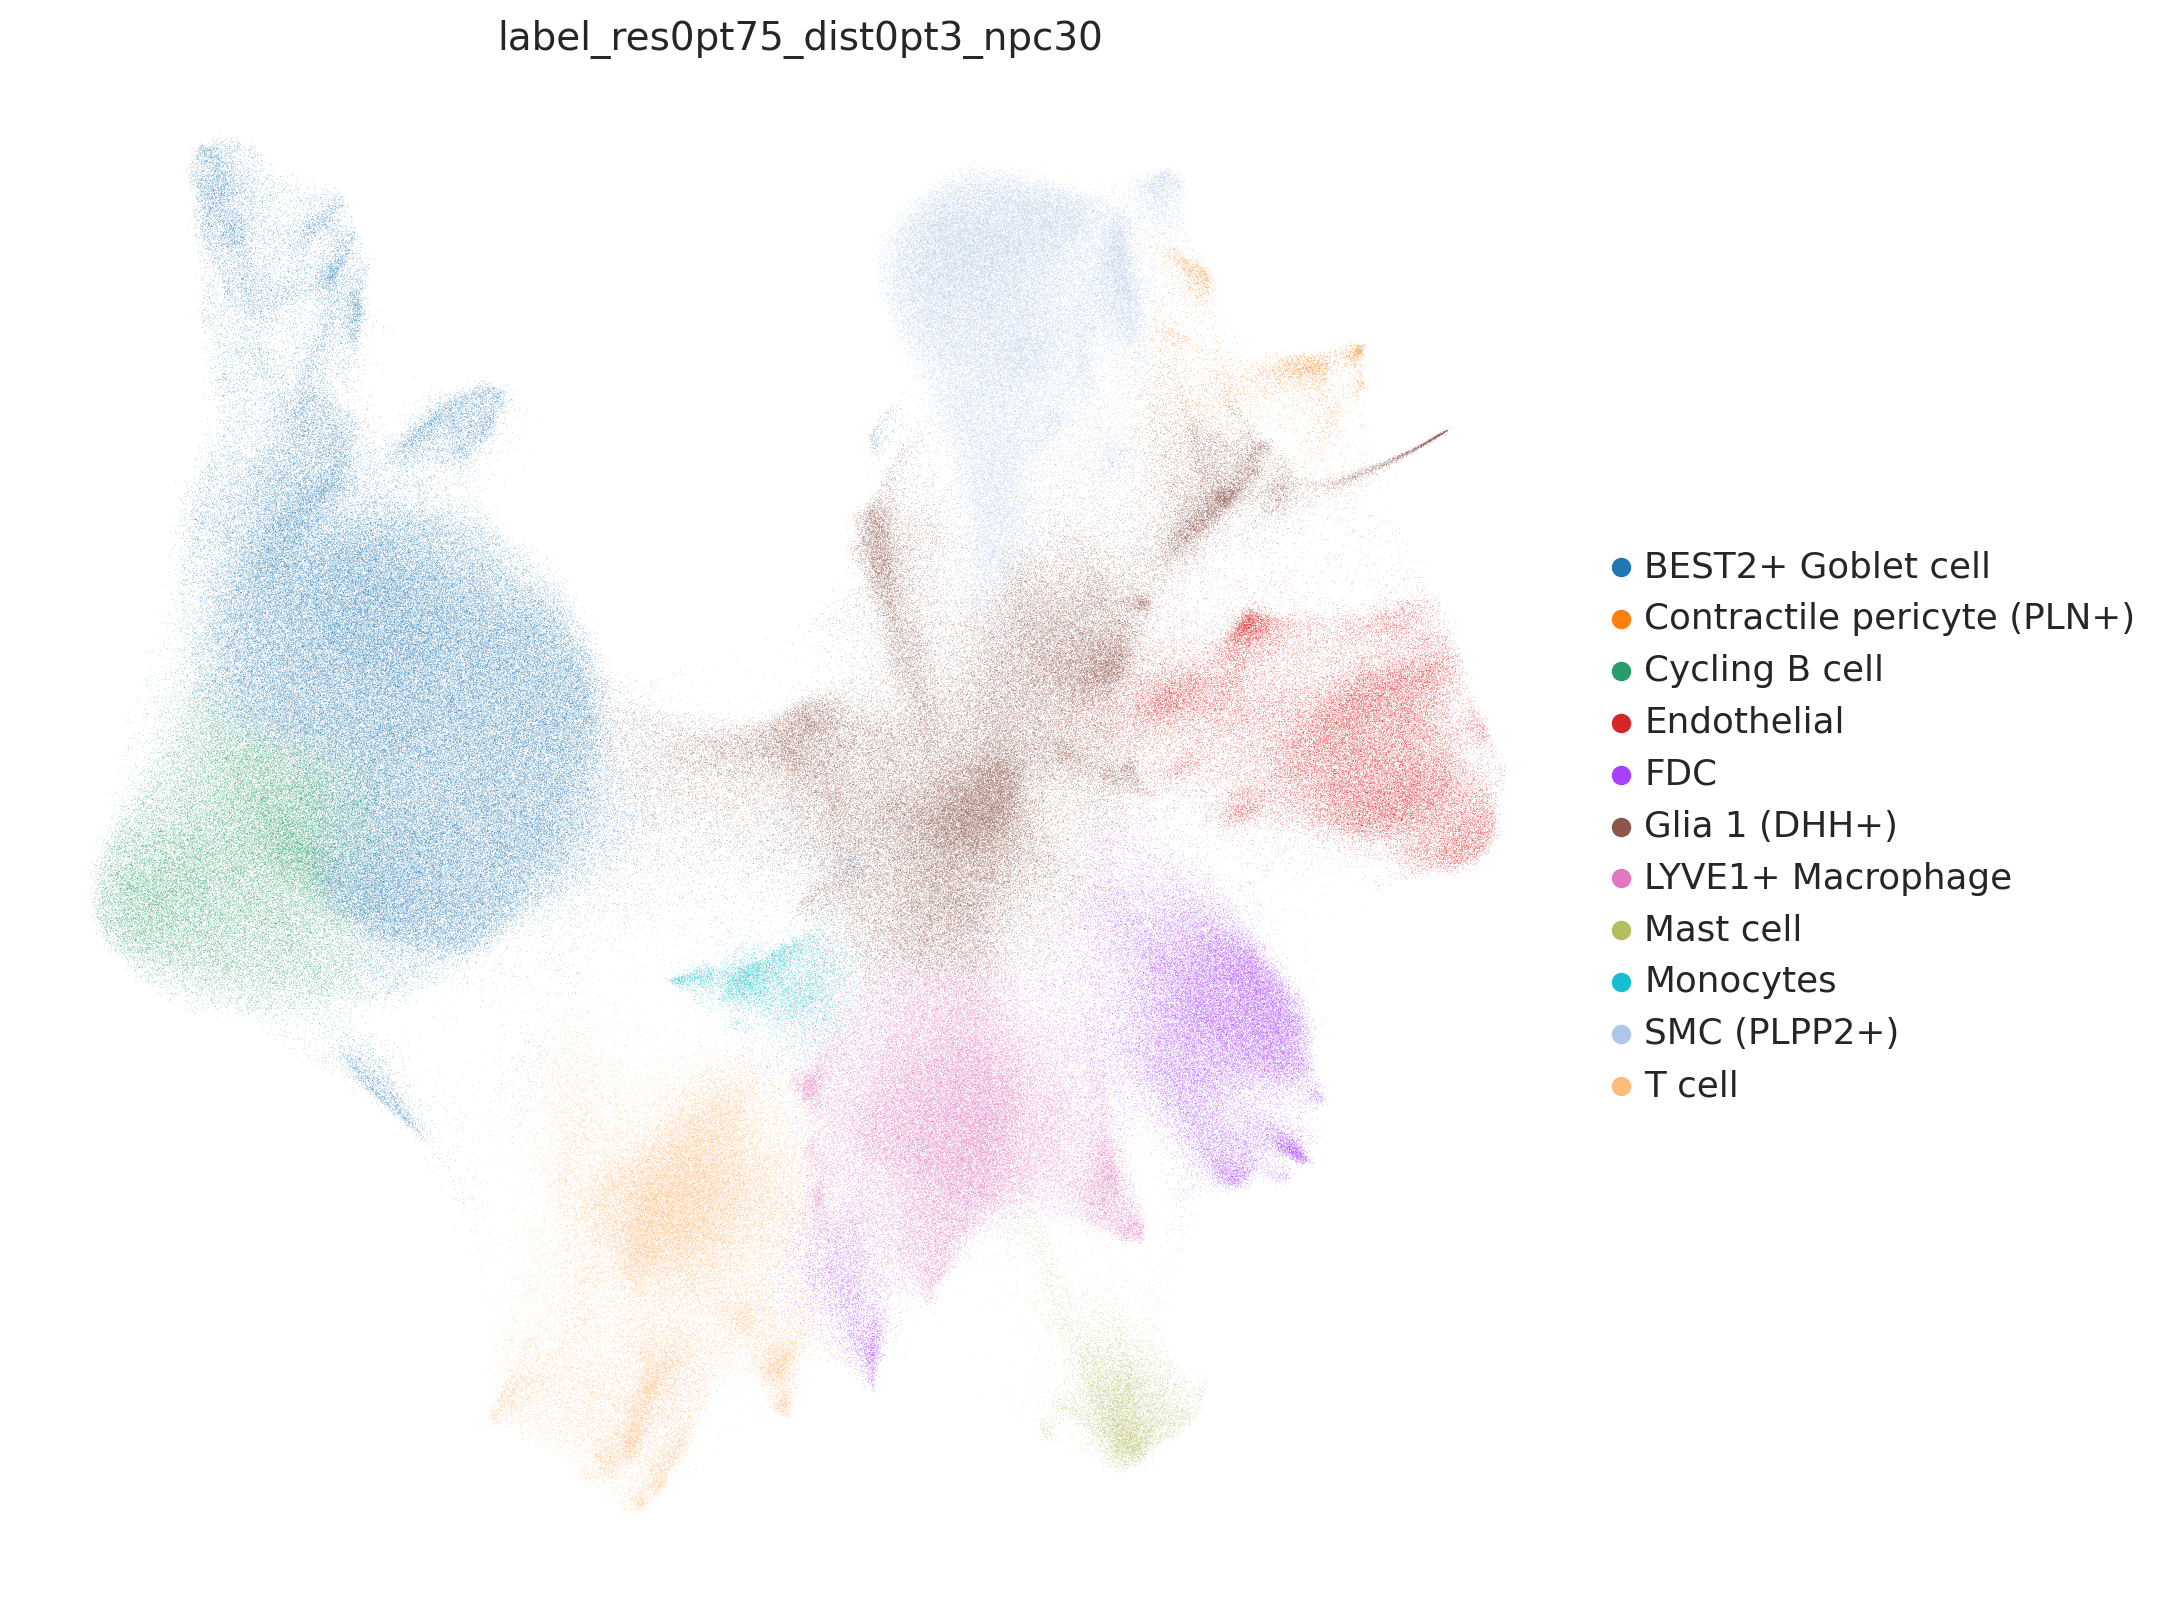

Markers File: /mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/Inflamed-50217A___leiden_res0pt75_dist0pt3_npc30_markers.csv
Clusters File: /mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/Inflamed-50217A___leiden_res0pt75_dist0pt3_npc30.csv


Markers File: /mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/Inflamed-50217A___label_res0pt75_dist0pt3_npc30_markers.csv
Clusters File: /mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/Inflamed-50217A___label_res0pt75_dist0pt3_npc30.csv




res1pt5_dist0_npc30




Un-used Keyword Arguments: {'assay': None}


<<< PERFORMING PCA >>>
{'use_highly_variable': False, 'n_comps': 30, 'random_state': 0}



<<< COMPUTING NEIGHBORHOOD GRAPH >>>
{'random_state': 0, 'n_pcs': 30}



<<< EMBEDDING UMAP >>>
{'random_state': 0, 'method': 'umap', 'min_dist': 0}



<<< CLUSTERING WITH LEIDEN METHOD >>>
Resolution=1.5


In [ ]:
%%time

print("\n\n", kws_pp, "\n\n")
for i, s in enumerate(selves):
    f_o = str(selves[i].rna.obs.out_file.iloc[0])

    # Preprocessing
    if "highly_variable" not in s.rna.var:
        _ = s.preprocess(**kws_pp, figsize=(15, 15))  # preprocess

    # Clustering at Different Resolutions & Minimum Distances
    for j, x in enumerate(kws_clustering):

        # Variables & Output Files
        print(f"\n\n{'=' * 80}\n{x}\n{'=' * 80}\n\n")
        cct, cca = f"leiden_{x}", f"label_{x}"  # Leiden & annotation columns
        if cct in s.rna.obs:
            continue
        annot = assign[[col_assignment[j]]]  # gene-annotation dictionary

        # Clustering, Markers, Annotation, & Writing Output
        _ = s.cluster(**kws_clustering[x], key_added=cct, out_file=f_o)
        if load is False or f"rank_genes_groups_{cct}" not in s.rna.uns:
            _ = s.find_markers(col_cell_type=cct, kws_plot=False)  # DEGs
        if reannotate is True or load is False:  # annotate; Explorer files
            _ = s.annotate_clusters(annot, col_cell_type=cct,
                                    col_annotation=cca)  # annotate
            for c in [k for k in [cct, cca] if k in s.rna.obs]:  # Explorer
                s.write_clusters(out_dir, col_cell_type=c, overwrite=True,
                                 file_prefix=f"{s._library_id}__", n_top=True)
        s.write(f_o)

## Tangram Imputation

In [ ]:
%%time

if file_sc is not None:
    adata_sc = sc.read(file_sc)  # read whole tx'ome data for imputation
    if load is False:
        for i, s in enumerate(selves):
            out = s.impute(
                adata_sc.copy(), col_cell_type=col_cell_type_sc,
                mode="clusters", markers=None, plot=False, plot_density=False,
                plot_genes=None, col_annotation=col_tangram, out_file=None)
            out[0].write_h5ad(os.path.splitext(selves[
                0].rna.obs.out_file.iloc[0])[0] + "___tangram.h5ad")  # write
            s.write(s.rna.obs.out_file.iloc[0])
            s.write_clusters(out_dir, file_prefix=f"{s._library_id}___",
                             col_cell_type=col_tangram,
                             overwrite=True, n_top=True)
    s.plot_spatial(color=col_tangram)

## Plot Clusters

In [ ]:
for s in selves:
    s.plot_spatial(color=col_tangram)
    for j, x in enumerate(kws_clustering):
        _ = s.plot_spatial(color=[f"leiden_{x}",, f"label_{x}"])

## ToppGene

In [22]:
self = selves[0]

srcs = ["Cells of the human intestinal tract mapped across space and time",
        "Human Ileal Epithelial cells from Crohn’s Disease",
        "Human Ileal Immune cells from Crohn’s Disease"]
# cct = "leiden_res0pt5_dist0pt5_npc30"
# cct = "leiden_res0pt75_dist0pt3_npc30"
c_t = "leiden_res1pt5_dist0_npc30"

tgdf, mks = self.annotate_clusters(
        None, sources=srcs, col_cell_type=c_t, max_results=10000,
        name_pattern={srcs[0]: "SmallIntestine"}, p_threshold=1e-15,
        n_top_genes=20, n_top_annotations=20)
tgdf.loc[:, "Name"] = tgdf.Name.str.strip(
        " / Per Region, Age_group, Lineage, cell class, cell type   ").apply(
                lambda x: re.sub("SmallIntestine", "SmInt", " --- ".join(
                        x.split("|")[0].split("-"))))

In [125]:
clus = "23"

print(mks.loc[clus].index.values, "\n\n")
print(assign.loc[mks.loc[clus].index.intersection(assign.index)].iloc[
    :, [0]].rename_axis("Gene").reset_index().groupby("group").apply(
        lambda x: ", ".join(x.Gene.unique())))
print(tgdf.loc[clus].iloc[:, :-3])
assign.loc[mks.loc[clus].index.intersection(
    assign.index)].iloc[:, [0]].rename_axis("Gene").iloc[
        :, 0].str.get_dummies(',').groupby("Gene").max().replace(
            0, "").replace(1, "***")

['HHIP' 'NPNT' 'COL1A1' 'COL1A2' 'ACTA2' 'COL4A2' 'ADAMDEC1' 'FLNA'
 'COL4A1' 'ADAM28' 'MYLK' 'TAGLN' 'MYH11' 'CSRP1' 'CSF1' 'CNN1' 'MMP19'
 'BMP5' 'PDLIM7' 'FOS'] 


group
CX3CR1+ CD8 Tmem                                           FLNA
Distal progenitor                                          FLNA
Glia 1 (DHH+)                    COL1A1, COL1A2, COL4A2, COL4A1
MMP9+ Inflammatory macrophage                          ADAMDEC1
Megakaryocyte                                            PDLIM7
Memory B                                                 ADAM28
Neural                                                   COL1A1
SMC                                                       ACTA2
SMC (PLPP2+)                                  MYLK, MYH11, CNN1
Stromal 1 (ADAMDEC1+)                                    ADAM28
Stromal 1 (CCL11+)                                     ADAMDEC1
Stromal 2 (NPY+)                                           BMP5
Stromal 3 (C7+)                                          CO

,CX3CR1+ CD8 Tmem,Distal progenitor,Glia 1 (DHH+),MMP9+ Inflammatory macrophage,Megakaryocyte,Memory B,Neural,SMC,SMC (PLPP2+),Stromal 1 (ADAMDEC1+),Stromal 1 (CCL11+),Stromal 2 (NPY+),Stromal 3 (C7+),angiogenic pericyte,myofibroblast
Gene,,,,,,,,,,,,,,,
ACTA2,,,,,,,,***,,,,,,,
ADAM28,,,,,,***,,,,***,,,,,
ADAMDEC1,,,,***,,,,,,,***,,,,
BMP5,,,,,,,,,,,,***,,,
CNN1,,,,,,,,,***,,,,,,
COL1A1,,,***,,,,***,,,,,,***,,
COL1A2,,,***,,,,,,,,,,,,
COL4A1,,,***,,,,,,,,,,,***,
COL4A2,,,***,,,,,,,,,,,***,


# Analyze

## Centrality Scores

In [11]:
%%time

for s in selves:
    s.calculate_centrality(n_jobs=sc.settings.n_jobs)

	*** Building connectivity matrix...


KeyError: "Only a column name can be used for the key in a dtype mappings argument. 'use_highly_variable' not found in columns."

## Neighborhood Enrichment Analysis

In [ ]:
%%time

for s in selves:
    _ = s.calculate_neighborhood(figsize=(60, 30))

## Cell Type Co-Occurrence

In [ ]:
%%time

for s in selves:
    _ = s.find_cooccurrence(figsize=(60, 20), kws_plot=dict(wspace=3))

## Spatial Clustering

In [ ]:
for s in selves:
    cct = f"leiden_spatial_{list(kws_clustering.keys())[-1]}"
    _ = s.cluster_spatial(key_added=cct,
                          **kws_clustering[list(kws_clustering.keys())[-1]])
    _ = s.find_markers(col_cell_type=cct, kws_plot=False)
    _ = s.annotate_clusters(assign[[col_assignment[-1]]], col_cell_type=cct,
                            col_annotation=f"annotation_{cct}")
    for c in [cct, f"annotation_{cct}"]:
        s.plot_spatial(c)
        if out_dir is not None:
            s.write_clusters(out_dir, col_cell_type=c,
                             n_top=True, overwrite=True,
                             file_prefix=f"{s._library_id}___")
    if out_dir is not None:
        s.write(str(s.rna.obs.out_file.iloc[0]))

## Spatially-Variable Genes

In [ ]:
%%time

kws = dict(kws_plot=dict(legend_fontsize="large"), figsize=(15, 15))
for s in selves:
    _ = s.find_svgs(genes=15, method="moran", n_perms=10, **kws)

## Receptor-Ligand Interactions

In [ ]:
%%time

for s in selves:
    kss, ktt = None, None
    _ = s.calculate_receptor_ligand(
        col_condition=False, p_threshold=0.01, remove_ns=True,
        figsize=(30, 20), top_n=25, key_sources=kss, key_targets=ktt)
    # s.calculate_receptor_ligand_spatial()

## Cell Type Composition 

In [ ]:
for s in selves:
    s.run_composition_analysis()

## GEX

In [ ]:
for s in selves:
    s.plot_spatial(color=["TNF", "IL23", col_cell_type])

In [ ]:
_ = self.calculate_spatial_distance("LTi-like NCR+ ILC3", genes="CSF2RB")

In [ ]:
adata.X = adata.layers["counts"]
sq.tl.var_by_distance(
    adata, "LTi-like NCR+ ILC3", col_cell_type, library_key=col_sample_id,
    design_matrix_key="design_matrix", covariates=["Patient", "Inflamed"],
    metric="euclidean", spatial_key=self._spatial_key, copy=False)
sq.pl.var_by_distance(
    adata=adata, var=["CSF2RB", "CSF2RA", "IL7R"],
    anchor_key="LTi-like NCR+ ILC3",
    covariate="Inflamed")

# Workspace

## Manual Annotations

50452

## GEX

In [ ]:
for self in selves:
    self.update_from_h5ad(str(self.rna.obs.out_file.iloc[0]))

In [ ]:
i = 0
s = selves[i]
r = "leiden_res1.5_dist0_npc30"
s.get_layer("counts", inplace=True)
print(np.mean(s.rna[s.rna.obs[f"leiden_{r}"] == "9"][:, "CD79A"].X > 0))
print(np.mean(s.rna[s.rna.obs[f"leiden_{r}"] == "9"][:, "CD79B"].X > 0))
print(np.mean(s.rna[s.rna.obs[f"leiden_{r}"] == "6"][:, "CD79A"].X > 0))
print(np.mean(s.rna[s.rna.obs[f"leiden_{r}"] == "6"][:, "CD79B"].X > 0))
print(np.mean(s.rna[s.rna.obs[f"leiden_{r}"] == "6"][
    :, "ADAMDEC1"].X > 0))

In [ ]:
for x in ["COL1A1", "PEG10", "RCN3"]:
    print(np.mean(s.rna[s.rna.obs[f"leiden_{r}"] == "10"][:, x].X > 0))

In [ ]:
for x in ["BMP5", "F3", "MMP11", "CCL8", "NPY", "CH25H"]:
    print(np.mean(s.rna[s.rna.obs[f"leiden_{r}"] == "15"][:, x].X > 0))

In [ ]:
for x in ["LGR5"]:
    print(np.mean(s.rna[s.rna.obs[f"leiden_{r}"] == "16"][:, x].X > 0))

In [ ]:
for x in ["CRIP2", "KCNA5", "LBH", "NET1", "PLN", "RERGL"]:
    print(round(np.mean(s.rna[s.rna.obs[f"leiden_{r}"] == "20"][:, x].X > 0) * 100, 0))

In [ ]:
for x in ["TPSAB1", "CMA1"]:
    print(np.mean(s.rna[s.rna.obs[f"leiden_{r}"] == "21"][:, x].X > 0))

In [ ]:
for x in ["GNLY", "GZMB"]:
    print(np.mean(s.rna[s.rna.obs[f"leiden_{r}"] != "23"][:, x].X > 0))

In [ ]:
for x in marker_genes_dict["Pericyte"]:
    print(int(100 * np.mean(s.rna[s.rna.obs[f"leiden_{r}"] == "25"][
        :, x].X > 0)), " vs. ", int(100 * np.mean(s.rna[s.rna.obs[
            f"leiden_{r}"] != "25"][:, x].X > 0)))

In [ ]:
comp = "2"
print(", ".join([x + ": " + str(int(100 * np.mean(s.rna[s.rna.obs[
    f"leiden_{r}"] == "11"][:, x].X > 0))) + " vs. " + str(int(
        100 * np.mean(s.rna[s.rna.obs[f"leiden_{r}"] == comp][
            :, x].X > 0))) + "%" for x in ["COL4A1", "COL4A2", "DLC1"]]))
print(f"\n...compared to {comp}")

In [ ]:
print(", ".join([x + ": " + str(int(100 * np.mean(s.rna[s.rna.obs[
    f"leiden_{r}"] == "9"][:, x].X > 0))) + " vs. " + str(int(
        100 * np.mean(s.rna[s.rna.obs[f"leiden_{r}"] != "9"][
            :, x].X > 0))) + "%" for x in [
                "ZBTB38", "IFNAR2", "SELENOM", "XBP1"]]))

In [ ]:
# Memory B
# Stricture-50452C___leiden_res0.75_dist0.3_npc30
i = -1
s = selves[i]
r = "leiden_res0.75_dist0.3_npc30"
s.rna.obs.loc[:, f"leiden_{r}"] = s.rna.obs[
    f"leiden_{r}"].astype(float).astype(int).astype(str)
clid = "21"
comp = ["2", "16", "18"]
print(", ".join([x + ": " + str(int(100 * np.mean(s.rna[s.rna.obs[
    f"leiden_{r}"] == clid][:, x].X > 0))) + " vs. " + str(int(
        100 * np.mean(s.rna[s.rna.obs[f"leiden_{r}"].isin(comp)][
            :, x].X > 0))) + "%" for x in [
                "GPR183", "HHEX", "INPP5D", "LRRK2"]]))
print(f"\n...compared to {comp}")

In [ ]:
# Naive B
# Stricture-50452C___leiden_res0.75_dist0.3_npc30
i = -1
s = selves[i]
r = "leiden_res0.75_dist0.3_npc30"
s.rna.obs.loc[:, f"leiden_{r}"] = s.rna.obs[
    f"leiden_{r}"].astype(float).astype(int).astype(str)
clid = "21"
comp = ["2", "16", "18"]
print(", ".join([x + ": " + str(int(100 * np.mean(s.rna[s.rna.obs[
    f"leiden_{r}"] == clid][:, x].X > 0))) + " vs. " + str(int(
        100 * np.mean(s.rna[s.rna.obs[f"leiden_{r}"].isin(comp)][
            :, x].X > 0))) + "%" for x in [
                "IRF1", "LNPEP", "PLAC8", "IFITM1"]]))
print(f"\n...compared to {comp}")

In [148]:
# Epithelial
# Uninflamed-50006B
i = 0
s = selves[i]
r = "leiden_res1pt5_dist0_npc30"
clus = "26"
# comp = ["10", "28"]
# comp = ["1", "3", "4", "7", "8", "10", "20", "26"]
# comp = ["3", "4", "7", "8", "10", "26"]
comp = ["4", "7", "8", "9"]  # suspected goblets
# comp = ["8"]
comp = list(set(comp).difference(set([clus])))
ccc = ", ".join([x + ": " + str(int(100 * np.mean(s.rna[s.rna.obs[r] == clus][
    :, x].X > 0))) + " vs. " + str(int(100 * np.mean(s.rna[s.rna.obs[
        r].isin(comp)][:, x].X > 0))) + "%" for x in [
            "MUC2", "MUC4", "MUC1", "KLK1", "ZG16",  # "FAM3D",
            "BEST2", "BEST4","LGR5", "CDCA7", "CCL20", "LYZ",
            "HCK", "MATK", "ZFHX3"]])  # Tuft markers
f"{clus} compared to {comp}: {ccc}"

"26 compared to ['8', '9', '7', '4']: MUC2: 36 vs. 60%, MUC4: 58 vs. 71%, MUC1: 41 vs. 55%, KLK1: 49 vs. 60%, ZG16: 40 vs. 76%, BEST2: 12 vs. 38%, BEST4: 2 vs. 9%, LGR5: 2 vs. 1%, CDCA7: 34 vs. 17%, CCL20: 30 vs. 23%, LYZ: 26 vs. 20%, KIT: 58 vs. 2%, HCK: 23 vs. 2%, MATK: 16 vs. 0%, ZFHX3: 31 vs. 17%"

In [153]:
# Eptithelial
# Uninflamed-50006B
i = 0
s = selves[i]
r = "leiden_res1pt5_dist0_npc30"
clus = "26"
comp = ["10", "28"]
# comp = ["1", "3", "4", "7", "8", "10", "20", "26"]
# comp = ["3", "4", "7", "8", "10", "26"]
# comp = ["4", "7", "8", "9"]  # suspected goblets
# comp = ["8"]
comp = list(set(comp).difference(set([clus])))
ccc = ", ".join([x + ": " + str(int(100 * np.mean(s.rna[s.rna.obs[r] == clus][
    :, x].X > 0))) + " vs. " + str(int(100 * np.mean(s.rna[s.rna.obs[
        r].isin(comp)][:, x].X > 0))) + "%" for x in [
            "MUC5B", "KIT", "MARCKSL1", "NACA", "FAM3D", "LCN2", "IRF2BP2",
            "MUC4", "SATB2", "UQCRC1", "SLC39A8", "SERBP1", "TP53", "MYO10",
            "KLK1", "HMGB1", "HOXA3", "NR5A2", "CAT", "LIMA1", "COX8A",
            "LGALS9", "HMGB2", "CDCA7", "ZFP91", "MUC1", "ATF6B"]])
f"{clus} compared to {comp}: {ccc}"

"26 compared to ['28', '10']: MUC5B: 86 vs. 2%, KIT: 58 vs. 0%, MARCKSL1: 76 vs. 24%, NACA: 99 vs. 81%, FAM3D: 90 vs. 91%, LCN2: 71 vs. 46%, IRF2BP2: 82 vs. 40%, MUC4: 58 vs. 6%, SATB2: 62 vs. 39%, UQCRC1: 74 vs. 57%, SLC39A8: 57 vs. 6%, SERBP1: 76 vs. 48%, TP53: 57 vs. 16%, MYO10: 54 vs. 31%, KLK1: 49 vs. 8%, HMGB1: 80 vs. 48%, HOXA3: 39 vs. 4%, NR5A2: 45 vs. 37%, CAT: 66 vs. 42%, LIMA1: 81 vs. 91%, COX8A: 54 vs. 44%, LGALS9: 50 vs. 47%, HMGB2: 57 vs. 14%, CDCA7: 34 vs. 0%, ZFP91: 61 vs. 45%, MUC1: 41 vs. 13%, ATF6B: 50 vs. 33%"

In [147]:
ggc = ["HCK", "MATK", "ZFHX3"]
subs = s.rna[s.rna.obs[r] == clus].copy()
subs = sc.tl.score_genes(subs, ggc, score_name="|".join(ggc),
                         use_raw=False, copy=True)  # score co-GEX
np.mean(subs.obs["|".join(ggc)] > 0)

0.3524904214559387

array(['ASS1', 'SPOCK1', 'PRCD', 'SHC1', 'ICA1', 'PBX3', 'CHRM3', 'RCAN2',
       'VAT1L', 'GLCCI1', 'NXPH2', 'PRSS3', 'PAQR8', 'CENPVL3', 'XPR1',
       'NELL1', 'KCNG1', 'SORCS3', 'DCC', 'STRA6', 'CHST1', 'ADRA2A',
       'TAC1', 'CARTPT', 'SYT4', 'ONECUT2', 'GRP', 'SNCG', 'TPD52',
       'NEFL', 'PENK', 'TMEFF2', 'RUNX1', 'ONECUT3', 'BRINP3', 'HTR3A',
       'SPOCK2', 'FDFT1', 'SQLE', 'PSD3', 'SLITRK5', 'PCDH19', 'RTN1',
       'AC010247.2', 'TNFSF13B', 'ATP6V0E2', 'HMGCS1', 'DHCR24', 'NRXN2',
       'ACAT2', 'SLC18A3', 'ASAH1', 'SEZ6', 'CHST8', 'MSMO1', 'TMEM255B',
       'FAT3', 'RIT2', 'NRCAM', 'HMGCR', 'FLRT2', 'DNER', 'IDI1',
       'GABBR2', 'MPZL1', 'SCUBE1', 'SEC11C', 'ELAVL2', 'TMEM145',
       'HS6ST2', 'SCD', 'SLC6A2', 'SCGN', 'ENC1', 'SSTR2', 'FILIP1',
       'CNGB1', 'TMOD1', 'GNG8', 'VIP', 'AKAP13', 'CXXC5', 'ALDH1A3',
       'GAL', 'PLXNA2', 'CPLX2', 'CREB5', 'KIF26A', 'FGF1', 'ETV1',
       'RNASE1', 'PIRT', 'PTGIR', 'NEUROD6', 'APLP2', 'NCOA7', 'MAP3K1',
       'FER

In [15]:
# Neural-Glia
# Uninflamed-50006B
i = 0
s = selves[i]
r = "leiden_res1pt5_dist0_npc30"
clus = "24"
comp = ["19"]
comp = list(set(comp).difference(set([clus])))
ccc = ", ".join([x + ": " + str(int(100 * np.mean(s.rna[s.rna.obs[r] == clus][
    :, x].X > 0))) + " vs. " + str(int(100 * np.mean(s.rna[s.rna.obs[
        r].isin(comp)][:, x].X > 0))) + "%" for x in assign[(
            assign.Bin == "Glia") & (
                assign.Bin != "Neural")].index.intersection(s.rna.var_names)])
f"{clus} compared to {comp}: {ccc}"

"24 compared to ['19']: IGFBP7: 50 vs. 61%, MT1E: 15 vs. 42%, SELENOM: 7 vs. 11%, SORBS2: 17 vs. 38%, ZFP36: 98 vs. 91%, GPX3: 38 vs. 83%, CCL2: 48 vs. 18%, S100B: 15 vs. 85%, COL4A1: 59 vs. 75%, COL4A2: 59 vs. 76%, COL1A1: 82 vs. 44%, COL1A2: 80 vs. 62%, NR4A1: 63 vs. 50%, CD44: 29 vs. 27%, ETS1: 22 vs. 22%, TGFB1: 16 vs. 14%, AQP1: 16 vs. 20%, BCAN: 0 vs. 1%, APOE: 1 vs. 15%, TPD52L1: 3 vs. 10%, CDCA7: 0 vs. 0%, C5orf30: 1 vs. 5%"

## CD34

In [ ]:
import matplotlib.pyplot as plt

gene = "CD34"
thr = np.arange(1, 15)  # thresholds
fig, axes = plt.subplots(1, len(selves))
for i, s in enumerate(selves):
    print(f"{s._library_id}: {np.sum(s.rna[:, gene].X > 0)} / {s.rna.n_obs}")
    a_x = axes[i].bar(thr, [np.sum(s.rna[:, gene].X >= i) for i in thr])
    axes[i].set_title(s._library_id)
    # for x in s.rna.obs[f"leiden_{r}"].unique():
    #     print(str(x) + ": " + np.mean(s.rna[s.rna.obs[
    #         f"leiden_{r}"] == x][:, "CD34"].X > 0))
fig.suptitle("Total Cells above Count Thresholds for CD34")

## CSF1/2

In [ ]:
for g in ["CSF1", "CSF2"]:
    print(f"\n\n{'=' * 80}\n{g}\n{'=' * 80}")
    for i, s in enumerate(selves):
        print(f"{s._library_id}: {np.sum(s.rna[:, g].X > 0)} / {s.rna.n_obs}")

## Aligned Images

In [ ]:
landmarks = ShapesModel.parse(
    np.array([[10556.699, 7829.764], [13959.155, 13522.025], [10621.200, 17392.116]]), geometry=0, radius=500
)
visium_sdata["visium_landmarks"] = visium_landmarks

xenium_landmarks = ShapesModel.parse(
    np.array([[9438.385, 13933.017], [24847.866, 5948.002], [34082.584, 15234.235]]), geometry=0, radius=500
)
xenium_sdata["xenium_landmarks"] = xenium_landmarks

In [ ]:
import spatialdata_io as sdio
from spatialdata.models import ShapesModel

fai = os.path.join(
    "~/corescpy/examples/data/spatial",
    "Stricture-50452C__P53Red_P16Green_DAPIBlue.ome.tif")
faa = os.path.join(
    "~/corescpy/examples/data/spatial",
    "Stricture-50452C__P53Red_P16Green_DAPIBlue_matrix.csv")

img = sdio.xenium_aligned_image(fai, faa)